In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def show_in_notebook(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.show()

Find the labels

In [2]:
img = cv2.imread('../img/highres_board.png',1)
h, w, ch = img.shape
# Find the green labeled point
green_low = np.array([0, 220, 0])
green_high = np.array([10, 255, 10])
mask = cv2.inRange(img, green_low, green_high)

# coord contains all the pixel coordinates showing green color
coord = cv2.findNonZero(mask)
# convert coord to np_array format
coord_xy = [[dot[0][0],dot[0][1]] for dot in coord]
np_coord = np.array(coord_xy)

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(np_coord)

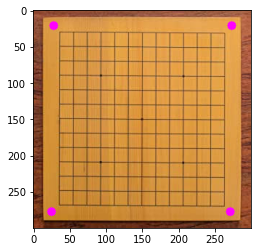

In [4]:
image = cv2.imread('../img/highres_board.jpeg')
for dot in kmeans.cluster_centers_:
    image = cv2.circle(image, (int(dot[0]),int(dot[1])), 6, (255, 0, 255), -1)
show_in_notebook(image)

In [5]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    rect[0] = pts[2]
    rect[1] = pts[0]
    rect[2] = pts[1]
    rect[3] = pts[3]
    return rect

Do Perspective Transformation

In [6]:
def four_point_transform(image, pts = kmeans.cluster_centers_):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

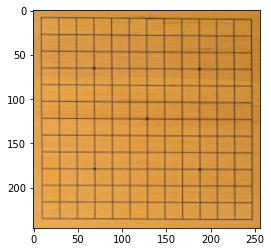

In [7]:
image = cv2.imread('../img/highres_board.jpeg')
pts = kmeans.cluster_centers_
warped = four_point_transform(image, pts)
show_in_notebook(warped)

In [8]:
newbaseImg = warped.copy()

Find Edges in Rectified Image

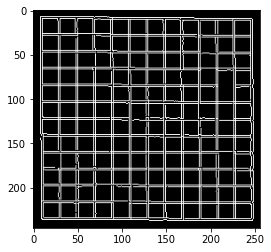

In [9]:
gray = cv2.cvtColor(newbaseImg, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(newbaseImg,110,320,apertureSize = 3)
show_in_notebook(edges)

Hough Transformation To Find Lines

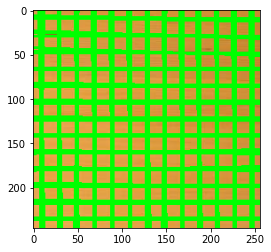

In [10]:
lines = cv2.HoughLines(edges,1,np.pi/180,110)
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))
    cv2.line(newbaseImg,(x1,y1),(x2,y2),(0,255,0),2)

show_in_notebook(newbaseImg)

Group Vertical and Horizontal Lines

In [11]:
hori = []
verti = []

for line in lines:
    rho, theta = line[0]
    if theta <= 1.8 and theta >= 1.2:
        verti.append(line)
    else:
        hori.append(line)

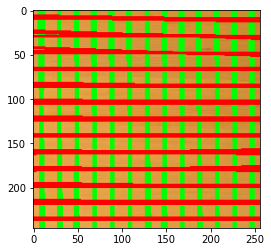

In [12]:
newbaseImg = warped.copy()

for line in hori:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))
    cv2.line(newbaseImg,(x1,y1),(x2,y2),(0,255,0),2)
for line in verti:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))
    cv2.line(newbaseImg,(x1,y1),(x2,y2),(0,0,255),2)
show_in_notebook(newbaseImg)

Find Intersections

In [13]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.
    Returns closest integer pixel locations.
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [x0, y0]

intersections = []
for xline in hori:
    for yline in verti:
        intersections.append(intersection(xline, yline))

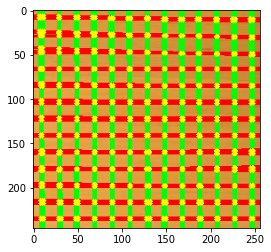

In [14]:
for intersect in intersections:
    x0 = intersect[0]
    y0 = intersect[1]

    img = cv2.circle(newbaseImg, (x0, y0), radius=2, color=(0, 255, 255), thickness=-1)
show_in_notebook(newbaseImg)

KMeans To Find Accurate Intersection Position

In [15]:
from sklearn.cluster import KMeans
X = np.array(intersections)
kmeans = KMeans(n_clusters=169, random_state=0).fit(X)

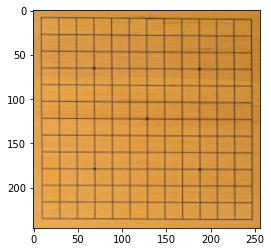

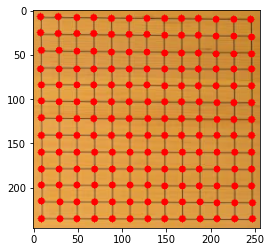

In [16]:
newbaseImg = warped.copy()
show_in_notebook(newbaseImg)
coord_array = np.array([[int(x[0]),int(x[1])] for x in kmeans.cluster_centers_])
for center in coord_array:
    img = cv2.circle(newbaseImg, [int(center[0]), int(center[1])], 4, (0,0,255), -1)
show_in_notebook(newbaseImg)